# Gruppenprojekt ML-Sensordaten

## Aufgabe 1: Überblick über die Daten

Ziel der Aufgabe ist es durch das Laden der Daten und den ersten Schritten der EDA einen **Überblick über Wertebereich einzelner Features, mögliche Korrelationen, Ausreißer und fehlender Werte** zu bekommen.

Das hilft uns dabei in den weiteren Schritten besser mit den Daten umgehen zu können, in dem wir ein Gefühl für die Daten bekommen und mögliche Probleme frühzeitig erkennen.

### 1.1 Laden des Datensatzes und allen benötigten Paketen

- Einlesen der Datei `Dataensatz-Sensor.csv` mit `pandas.read_csv()`
- Setzen eines sinnvollen Index (hier: Zeitstempel 'Datum'), für spätere Analysen hilfreich
- Umwandlung der Spalte `Datum` in ein echtes Datumsformat (`datetime`), damit Zeitreihenanalysen und Resampling später einfacher werden

**Ziel dieser Zelle**: Sicherstellen, dass die Daten korrekt geladen wurden (keine offensichtlichen Fehler, korrekte Spaltennamen, sinnvolle Datentypen als Ausgangspunkt)

In [35]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('../data/Datensatz-Sensor.csv', parse_dates=['Datum'])

# Wir wollen direkt sagen, dass unsere Timestamps auch der Index sind
df.set_index('Datum', inplace=True)
df.head()

# Wir wollen auch direkt die numerischen Spalten in einer Variablen speichern, da wir diese für die Analyse öfter brauchen werden
# Wir excludieren hier die Zielvariable 'Anwesenheit'
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Anwesenheit', errors='ignore')

### 1.2 Erster Überblick über Struktur und Datentypen

Um die Grundstruktur der Daten zu verstehen, schauen wir uns zunächst folgende Aspekte an:

- Wie viele Zeilen und Spalten der Datensatz hat (`df.shape`)
- Welche Spalten vorhanden sind und welche Datentypen sie aktuell haben (`df.info()`)
- OB es bereits an dieser Stelle Hinweise auf Probleme gibt (bspw. numerische Spalten, als object)

**Ziel dieser Zelle**: Verständnis über den grundlegenden Aufbau des DataFrames und die aktuell gesetzten Datentypen für jedes Feature

In [36]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19236 entries, 2015-02-02 14:19:00 to 2015-02-17 11:15:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperatur    19134 non-null  float64
 1   Feuchtigkeit  18915 non-null  float64
 2   CO2           19236 non-null  float64
 3   Wassergehalt  18777 non-null  float64
 4   Anwesenheit   19236 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 901.7 KB


((19236, 5), None)

### 1.3 Desriptive Statistiken und Wertebereiche der Features

Als nächstes betrachten wir einfache deskriptive Kennzahlen der numerischen Features, um grob die Wertebereiche zu erfassen:

- `df.describe()` liefert u.a. Minimum, Maximum, Mittelwert, Standardabweichung und Quantile
- Anhand von `min`und `max` können wir überprüfen, ob die Werte in realistischen Bereichen liegen (bspw. Temperatur in °C, Luftfeuchtigkeit in %. CO₂ in ppm, Wassergehalt in kg Wasserdampf/ kg Luft)
- Für die Zielvariable `Anwesenheit` prüfen wir, ob beide Klassen (0, 1) vorkommen und wie sie verteilt sind (Klassenbalance)

**Ziel dieser Zelle**: Ein erstes quantitatives Gefühl für typische Werte und Extreme der einzelnen Features zu bekommen.

In [37]:
# Deskriptive Statistiken
df

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
Datum,,,,,
2015-02-02 14:19:00,23.7000,26.272,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,779.000000,0.004767,1
...,...,...,...,...,...
2015-02-17 11:10:59,21.3900,32.440,1069.750000,0.005115,1
2015-02-17 11:12:00,21.3900,32.345,1079.500000,0.005100,1
2015-02-17 11:12:59,21.3900,32.290,1076.000000,0.005092,1


(Anwesenheit
 0    0.773394
 1    0.226606
 Name: proportion, dtype: float64,
 <Axes: >)

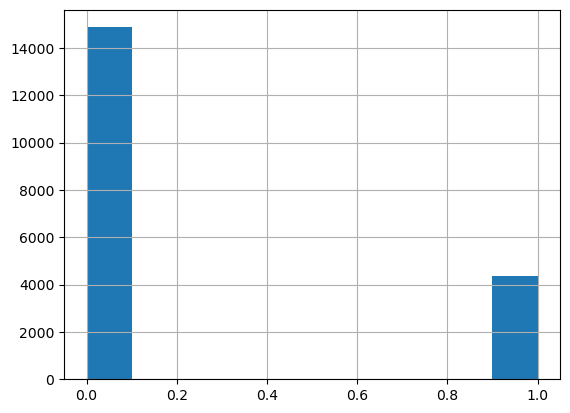

In [38]:
# Verteilung der Zielvariable (Klassenverteilung)
df['Anwesenheit'].value_counts(normalize=True), df['Anwesenheit'].hist()

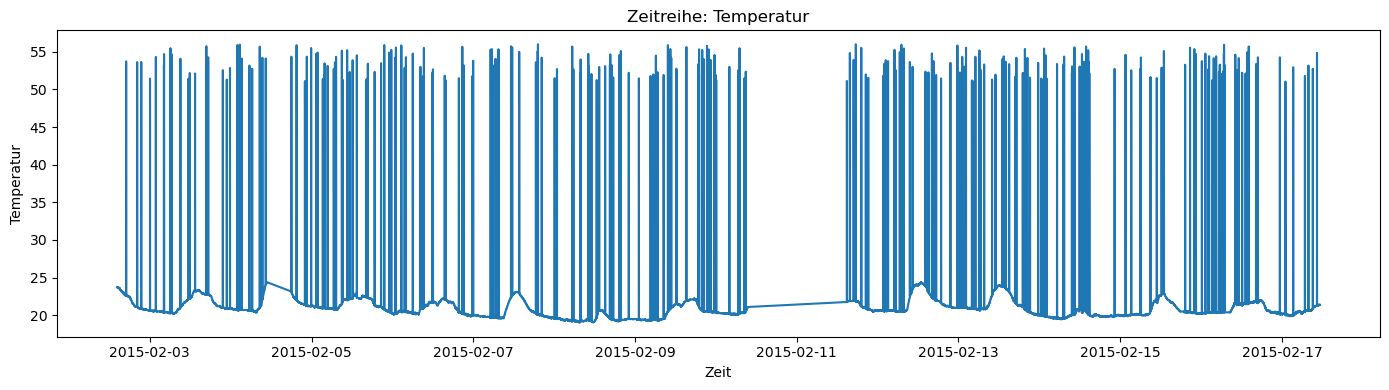

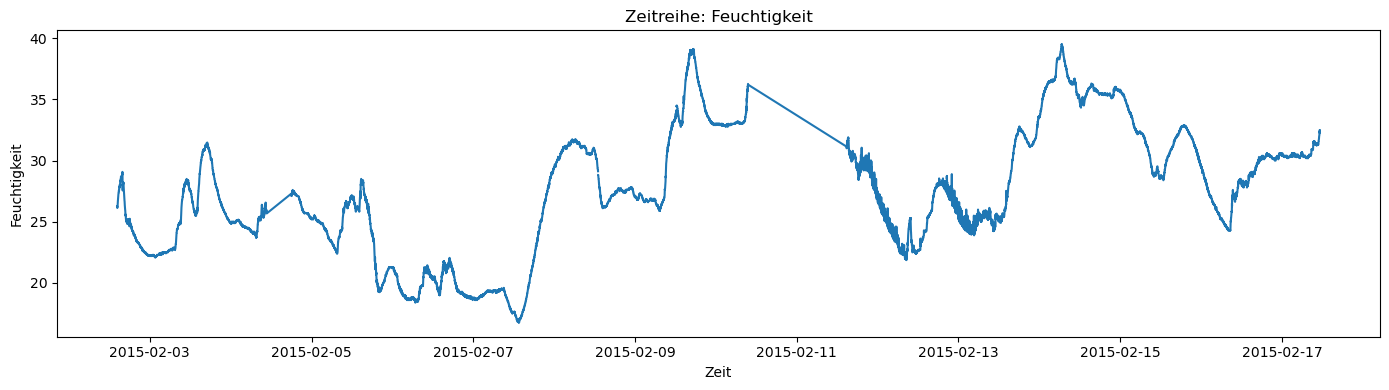

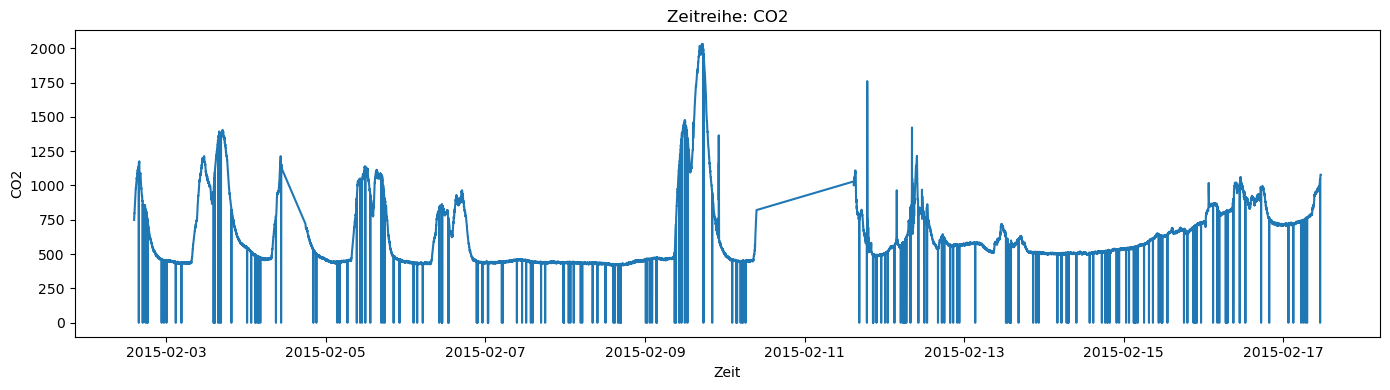

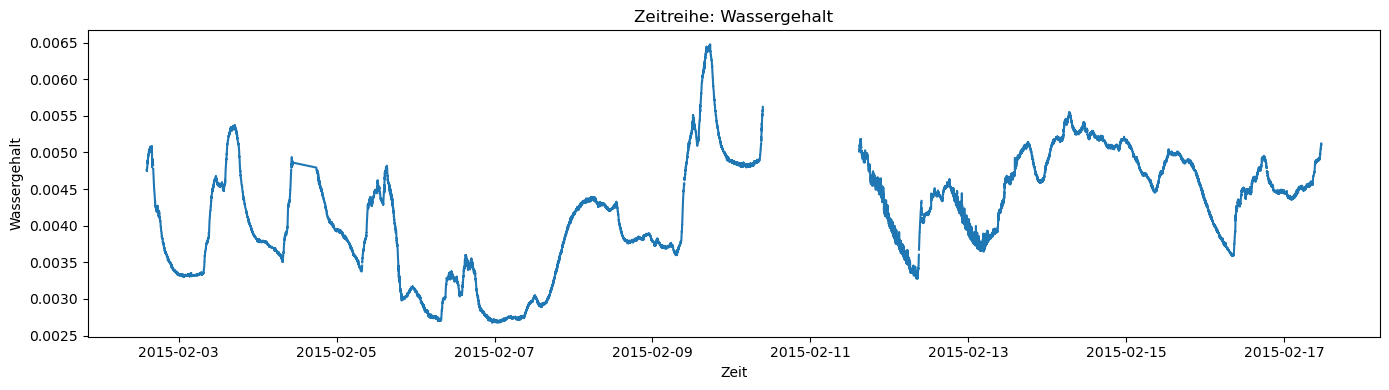

In [39]:
# Zeitreihen Analyse: Wassergehalt und Feuchtigkeit

for i, col in enumerate(numeric_cols, 1):
    plt.figure(figsize=(14,4))
    plt.plot(df[col])
    plt.title(f'Zeitreihe: {col}')
    plt.xlabel('Zeit')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


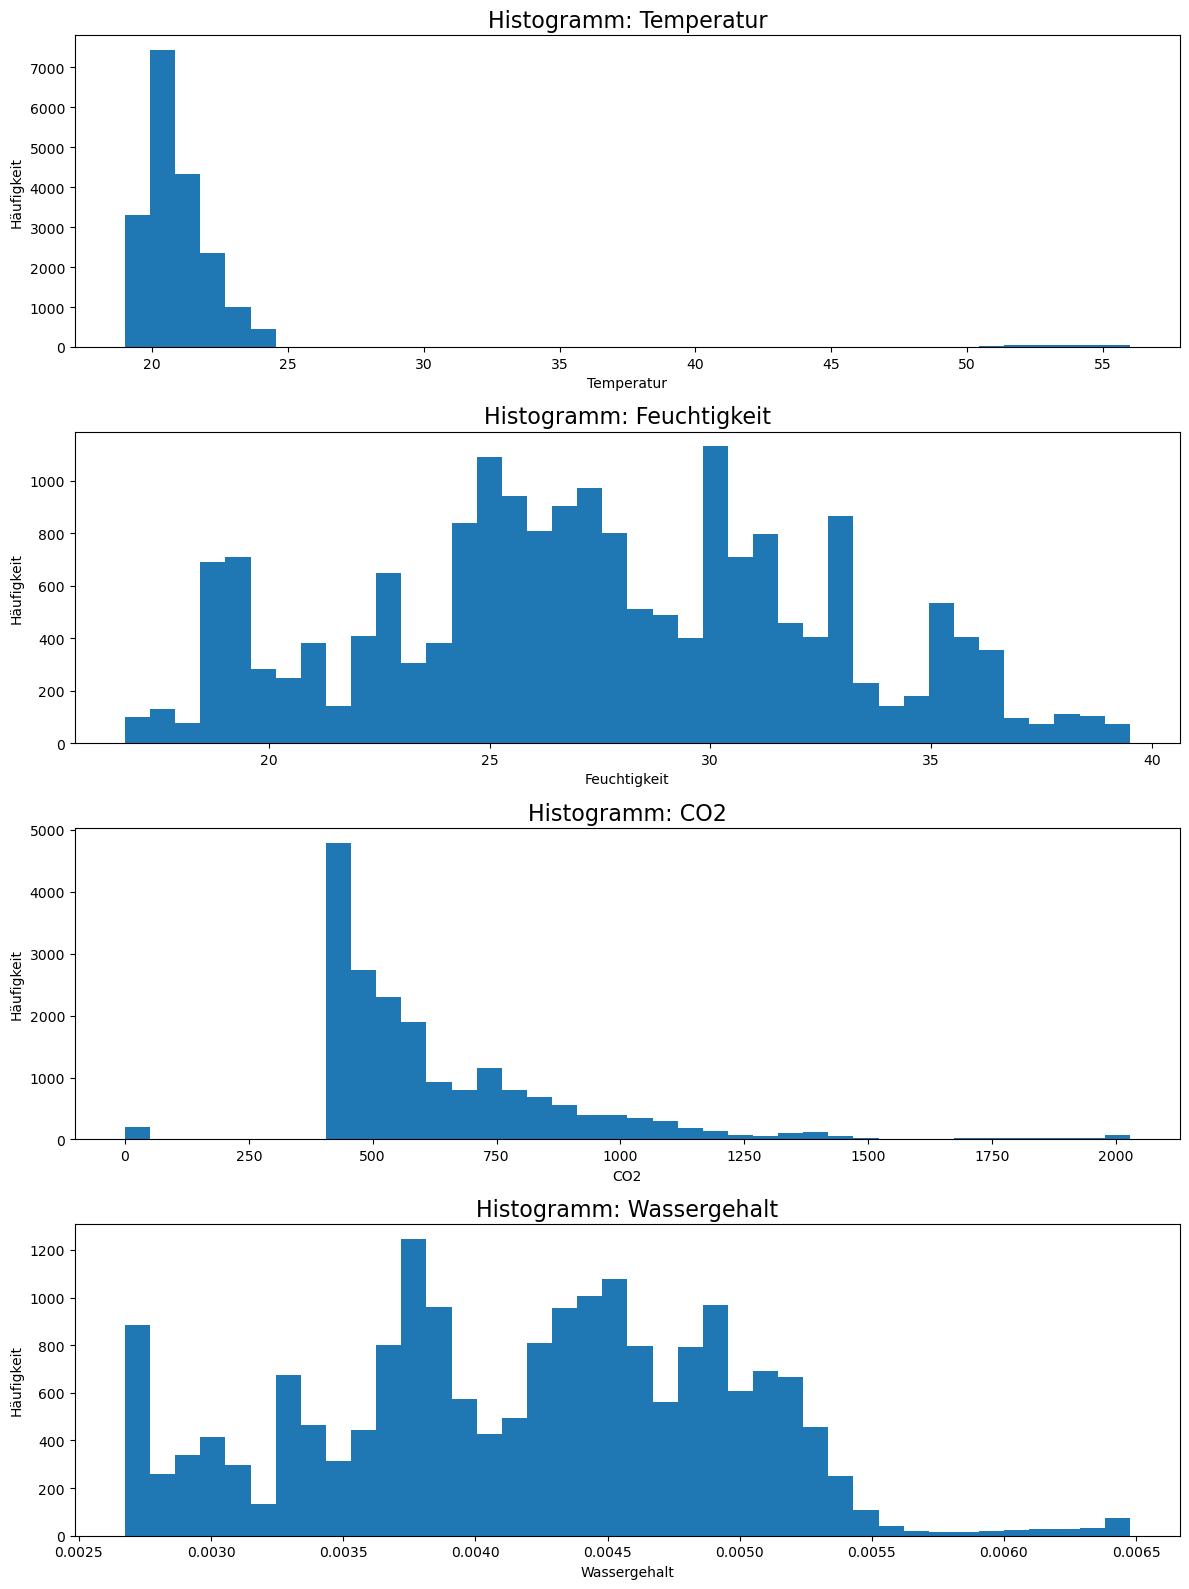

In [40]:
# Verteilung der numerischen Spalten

plt.figure(figsize=(12, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    plt.hist(df[col].dropna(), bins=40)
    plt.title(f'Histogramm: {col}', fontsize=16)
    plt.xlabel(col)
    plt.ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

### 1.4 Prüfung auf fehlende Werte

Fehlende Werte können ein Modell stark beeinflussen, daher prüfen wir frühzeitig, ob und wo `NaN`-Werte
auftreten:

- Mit `df.isna().sum()` sehen wir, wie viele fehlende Werte pro Spalte vorhanden sind.
- Falls Fehlstellen existieren, analysieren wir, ob diese zufällig verteilt sind oder systematisch, z. B. nur in bestimmten Zeitbereichen

**Ziel dieser Zelle:** Erkennen, ob im späteren Vorverarbeitungsschritt Strategien zum Umgang mit fehlenden
Werten (z. B. Imputation, Zeilenverwerfen) notwendig sind.

In [41]:
# Fehlende Werte je Spalte
df.isna().sum().sort_values(ascending=False)

Wassergehalt    459
Feuchtigkeit    321
Temperatur      102
CO2               0
Anwesenheit       0
dtype: int64

In [42]:
# Schauen ob diese fehlende Werte zufällig oder in bestimmten Zeitbereichen
(
    df
        .isna()
        .groupby(df.index.date)
        .sum()dd
)

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
2015-02-02,3,5,0,20,0
2015-02-03,11,16,0,36,0
2015-02-04,5,20,0,22,0
2015-02-05,10,14,0,35,0
2015-02-06,7,33,0,37,0
2015-02-07,8,26,0,44,0
2015-02-08,9,35,0,34,0
2015-02-09,7,28,0,20,0
2015-02-10,1,9,0,12,0
2015-02-11,1,13,0,15,0


### 1.5 Ausreißeranalyse

- Boxplots für die kontinuierlichen Features (z. B. `Temperatur`, `Luftfeuchtigkeit`, `CO₂`, `Wassergehalt`).
- Berechnung der Interquartilsabstände (IQR) und Markierung von Werten, die deutlich außerhalb
  von \[Q1 − 1,5·IQR, Q3 + 1,5·IQR\] liegen.

Wir dokumentieren dabei:
- In welchen Features auffällige Extremwerte auftreten.
- Ob diese Werte realistisch (z. B. seltene, aber mögliche Messungen) oder eher fehlerhaft erscheinen.

**Ziel dieser Zelle:** Erkennen potenzieller Ausreißerbereiche, die in Aufgabe 2 ggf. speziell behandelt werden
müssen (z. B. Kappung, Transformation oder vollständiges Entfernen von Zeilen).

In [45]:
# Ausreißer über IQR 

iqr_results = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Outlier-Markierung (True / False)
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()
    
    iqr_results[col] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower bound": lower_bound,
        "Upper bound": upper_bound,
        "Outlier count": outlier_count,
        "Outlier percentage (%)": round(100 * outlier_count / len(df), 2)
    }

# In DataFrame umwandeln für Übersicht
iqr_df = pd.DataFrame(iqr_results).T
iqr_df

,Q1,Q3,IQR,Lower bound,Upper bound,Outlier count,Outlier percentage (%)
Temperatur,20.133333,21.600000,1.466667,17.933333,23.800000,584.0,3.04
Feuchtigkeit,24.290000,31.050000,6.760000,14.150000,41.190000,0.0,0.00
CO2,454.500000,734.541667,280.041667,34.437500,1154.604167,1010.0,5.25
Wassergehalt,0.003699,0.004799,0.001100,0.002048,0.006450,9.0,0.05


### 1.6 Untersuchung möglicher Korrelationen

Als Nächstes analysieren wir die Zusammenhänge zwischen den numerischen Features:

- Berechnung der Korrelationsmatrix, z. B. mit `df.corr(numeric_only=True)`.
- Visualisierung der Korrelationen als Heatmap, um Muster auf einen Blick zu erkennen (z. B. starke
  Korrelation zwischen Temperatur und Wassergehalt sowie zwischen Luftfeuchtigkeit und Wassergehalt).

Dabei achten wir besonders auf:
- Stark korrelierte Features, die auf **Redundanzen** hindeuten und später bei der Modellauswahl oder
  Feature-Engineering eine Rolle spielen können.
- Den Zusammenhang zwischen den Sensorfeatures und der Zielvariable `Anwesenheit` (z. B. ob höhere CO₂-
  Werte typischerweise mit Anwesenheit von Personen einhergehen).

**Ziel dieser Zelle:** Ein erstes Verständnis dafür, welche Features vermutlich besonders relevant für die
Klassifikation sein könnten und wo Multikollinearität auftreten könnte.

In [46]:
df_sensor_corr = df.corr(numeric_only=True)
df_sensor_corr

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
Temperatur,1.000000,-0.059368,0.133788,0.042342,0.152282
Feuchtigkeit,-0.059368,1.000000,0.255548,0.930462,0.012673
CO2,0.133788,0.255548,1.000000,0.459315,0.616044
Wassergehalt,0.042342,0.930462,0.459315,1.000000,0.227703
Anwesenheit,0.152282,0.012673,0.616044,0.227703,1.000000


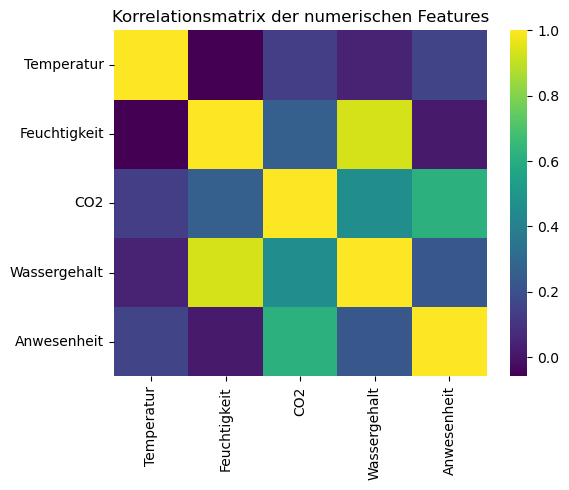

In [47]:
# Visualisierung als Heatmap

plt.figure(figsize=(6, 5))
sns.heatmap(df_sensor_corr, annot=False, cmap="viridis")
plt.title("Korrelationsmatrix der numerischen Features")
plt.tight_layout()
plt.show()

### Erkentnisse Aufgabe 1:

#### 📌 Zeitreihenanalyse

- Die Zeitverläufe der Sensorvariablen ermöglichen eine erste grobe Einschätzung typischer Muster im Verlauf der 15-tägigen Messperiode.
- CO₂ zeigt deutliche Peak-Strukturen, die typischerweise auf anwesende Personen im Raum zurückzuführen sind.
- Feuchtigkeit und Wassergehalt zeigen weichere Trends mit langsamerer Veränderung und tageszeitlichen Schwankungen.
- Temperatur ist über weite Teile des Zeitraums relativ stabil und verändert sich deutlich weniger als die anderen Variablen.
- In der Zeitreihe wurde ein Messfehler bzw. Messausfall erkannt (ein deutlicher Sprung bzw. Lücke von ca. 1–1,5 Tagen). Dies deutet auf fehlende Daten oder Sensorunterbrechungen hin und wird in Aufgabe 2 bei der Vorverarbeitung berücksichtigt.

#### 📌 Histogramme (Wertverteilungen)

- Die Histogramme zeigen die typischen Wertebereiche der Sensorvariablen und ob die Verteilungen symmetrisch, schief oder multimodal sind.
- CO₂ besitzt eine deutlich rechtsschiefe Verteilung mit langen Ausläufern nach oben, was auf häufige Peak-Ereignisse hinweist.
- Feuchtigkeit und Wassergehalt sind vergleichsweise symmetrisch verteilt, mit einigen Ausreißern.
- Temperatur weist eine eher konzentrierte Verteilung mit wenigen extremen Werten auf.

#### 📌 Ausreißeranalyse (IQR-Methode)

- Für jedes Feature wurden das 1. Quartil (Q1), das 3. Quartil (Q3) und der Interquartilsabstand (IQR) berechnet.
- Werte außerhalb von [Q1−1.5⋅IQR, Q3+1.5⋅IQR] wurden als Ausreißer markiert.
- CO₂ besitzt mit Abstand die meisten Ausreißer, was als realistischer Effekt interpretiert werden kann (kurzfristige Anwesenheitsphasen und Lüftungseinflüsse).
- Feuchtigkeit und Wassergehalt weisen ebenfalls mehrere Ausreißer auf, während Temperatur nur sehr wenige extreme Werte besitzt.
- Diese Ausreißer sind in vielen Fällen physikalisch plausibel und sollten nicht automatisch als Fehler entfernt werden.

#### 📌 Korrelationsanalyse

**Feature-Paar**	**Korrelation**
Feature-Paar|Korrelation
 --- | --- 
Feuchtigkeit ↔ Wassergehalt | 0.93 (sehr stark)
CO₂ ↔ Answesenheit | 0.62 (sehr stark)
CO₂ ↔ Wassergehalt | 0.46 (moderat)
CO₂ ↔ Feuchtigkeit | 0.26 (schwach-moderat)
Temperatur ↔ andere Variablen | < 0.15 (sehr schwach)


- Feuchtigkeit und Wassergehalt sind fast vollständig redundant (physikalisch plausibel).
- CO₂ korreliert moderat mit Wassergehalt, was ein starker Hinweis darauf ist, dass CO₂ später ein Hauptfeature zur Anwesenheitserkennung sein wird.
- Temperatur ist mit allen anderen Variablen kaum korreliert und daher vermutlich ein schwaches Prädiktor-Feature.

#### 📌 Hypothesen für die Modellierung (Ausblick)

Auf Basis der Analyse lassen sich folgende Hypothesen formulieren:

- CO₂ wird das wichtigste Feature zur Klassifikation der Anwesenheit sein.
- Wassergehalt oder Feuchtigkeit können als ergänzende Feature genutzt werden, sollten aber nicht beide gleichzeitig verwendet werden (Multikollinearität).
- Temperatur trägt vermutlich wenig Information über die Anwesenheit und kann als optionales Feature betrachtet werden.
- Die Datenlücke in der Zeitreihe muss in Aufgabe 2 behandelt werden (Imputation oder Resampling).
- Für CO₂ und Temperatur empfiehlt sich für weitere Analysen ein Rolling Window (Glättung) oder Resampling, da die Rohdaten stark verrauscht sind.

## Aufgabe 2: Vorverarbeitung der Daten

In diesem Abschnitt werden **geeignete Vorverarbeitungsschritte** definiert und umgesetzt.
Ziel ist ein Datenstand, der sich gut für das Training und die spätere Anwendung im Sensor eignet.

Typische Schritte:
- Behandlung von Ausreißern (z. B. Kappung, Entfernung, Transformation)
- Umgang mit fehlenden Werten (z. B. Imputation über Mittelwert/Median)
- Skalierung der Features (z. B. Standardisierung)
- Optional: Generierung neuer Features (z. B. gleitende Mittelwerte über Zeit, Ableitungen etc.)

Wichtig ist, dass alle Schritte **reproduzierbar** und **ohne Data Leakage** umgesetzt werden – also in einer
Form, die später unverändert auf neue Daten (versteckter Datensatz, Sensorbetrieb) angewendet werden kann.

### 2.1 Feature-Auswahl & Zielvariable

Für die Features wurden in Aufgabe 1 folgende Erkenntnisse gewonnen:

- **CO₂** korreliert stark mit der Zielvariable (`r ≈ 0.62`) und ist damit das wichtigste
  Einzel-Feature für die Anwesenheitserkennung.
- **Wassergehalt** und **Feuchtigkeit** sind extrem hoch miteinander korreliert (`r ≈ 0.93`),
  d. h. sie enthalten nahezu die gleiche Information (Redundanz).
- **Temperatur** zeigt weder zur Zielvariable noch zu den anderen Sensorwerten nennenswerte
  Korrelationen (< 0.1) und liefert damit nur sehr wenig zusätzliche Information.

Aus Sicht des Modells ist es sinnvoll, **redundante Features zu reduzieren** und nur eine der
beiden stark korrelierten Variablen zu verwenden. In diesem Projekt wird:

- **`CO2`** als zentrales Feature behalten,
- **`Wassergehalt`** als ergänzendes Feature genutzt,
- **`Feuchtigkeit`** aufgrund der starken Redundanz zu Wassergehalt entfernt,
- **`Temperatur`** aufgrund geringer Relevanz nicht in die finale Feature-Menge aufgenommen.

Damit entsteht ein kompaktes, gut interpretierbares Feature-Set.

In [78]:
# Zielvariable und Features definieren (Spaltennamen ggf. anpassen)
target_col = 'Anwesenheit'

# Manuell definierte Feature-Auswahl auf Basis von Aufgabe 1:
# - CO2: wichtigstes Feature
# - Wassergehalt: ergänzend, korreliert moderat mit CO2
# - Feuchtigkeit: redundant zu Wassergehalt (r ≈ 0.93) -> wird weggelassen
# - Temperatur: kaum Korrelation zur Zielvariable -> wird weggelassen
# - Wir wollen aber auch sicher gehen, dass die zwei versteckten Merkmale beachtet werden

# Features die wir ausschließen wollen
drop_cols = ['Temperatur', 'Feuchtigkeit', target_col]

def clean_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Wendet einfache, physikalisch begründete Reinigungsregeln auf den Roh-Datensatz an.
    Diese Funktion kann sowohl auf den aktuellen als auch auf verborgene Datensätze
    angewendet werden.
    """
    df = df.copy()
    
    # CO2: physikalisch unrealistische Werte behandeln
    if "CO2" in df.columns:
        # Untere Grenze (z.B. Außenluft ~ 350 ppm)
        co2_lower_bound = 300
        # Obere Grenze (optional, hier konservativ gewählt)
        co2_upper_bound = 5000
        
        df.loc[df["CO2"] < co2_lower_bound, "CO2"] = np.nan
        df.loc[df["CO2"] > co2_upper_bound, "CO2"] = np.nan

    # Wassergehalt: darf nicht negativ sein
    if "Wassergehalt" in df.columns:
        df.loc[df["Wassergehalt"] < 0, "Wassergehalt"] = np.nan

    # Feuchtigkeit: > 100 % ist physikalisch ungültig (falls später doch genutzt wird)
    if "Feuchtigkeit" in df.columns:
        df.loc[df["Feuchtigkeit"] > 100, "Feuchtigkeit"] = np.nan
    
    # Weitere Regeln könnten hier ergänzt werden, falls nötig
    
    return df


# Cleaning auf den aktuellen Datensatz anwenden
df_clean = clean_raw_data(df)

# Features: alles außer drop_cols
feature_cols = [col for col in df_clean.columns if col not in drop_cols]

X = df_clean[feature_cols].copy()
y = df_clean[target_col].copy()

print("Verwendete Features:", feature_cols)
print("Zielvariable:", target_col)

Verwendete Features: ['CO2', 'Wassergehalt']
Zielvariable: Anwesenheit


## 2.2 Train-Test-Split

Bevor Vorverarbeitungsschritte (Imputation, Skalierung) durchgeführt werden, wird der Datensatz in
**Trainings- und Testdaten** aufgeteilt. Dies verhindert Data Leakage, da alle Parameter der
Vorverarbeitung (z. B. Mittelwerte für Imputation, Skalierungsparameter) **nur aus den
Trainingsdaten** gelernt werden und anschließend auf die Testdaten angewendet werden.

Verwendet wird:

- ein Split von z. B. **70 % Training / 30 % Test**
- `stratify=y`, um die Klassenverteilung der Zielvariable in Train und Test möglichst ähnlich zu halten

In [ ]:
from sklearn.model_selection import train_test_split

# Train-Test-Split (bspw. 70/30, mit Stratifikation)
# Wir nutzen also stratify -> sorgt dafür, dass die Häufigkeitenverteilung: 
# 0 - 0.773394 
# 1 - 0.226606
# Über Test und Train daten gleich bleibt, damit nicht bspw nur 100% "nicht anwesend" oder 100% "anwesend"
# passieren kann. 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # sorgt für ähnliche Klassenverteilung in Train/Test
)

print("Train-Shape:", X_train.shape, "Test-Shape:", X_test.shape)
print("Klassenverteilung Training:\n", y_train.value_counts(normalize=True))
print("\nKlassenverteilung Test:\n", y_test.value_counts(normalize=True))

Train-Shpae: (13465, 2), Test-Shape: (5771, 2)

Klassenverteilung Training:, Anwesenheit
0    0.774304
1    0.225696
Name: proportion, dtype: float64

Klassenverteilung Test:
 Anwesenheit
0    0.77127
1    0.22873
Name: proportion, dtype: float64


### 2.3 Vorverarbeitungspipeline (Imputation + Skalierung)

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# alle numerischen Features bestimmen (auf Basis von X_train)
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # fehlende Werte (inkl. durch Cleaning erzeugte NaNs)
    ("scaler", StandardScaler())                    # Skalierung (wichtig für LogReg etc.)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ],
    remainder="drop"  # falls es später nicht-numerische Spalten gäbe
)

# Vorverarbeitung an den Trainingsdaten fitten
X_train_prepared = preprocessor.fit_transform(X_train)

# Gleiche Transformation auf Testdaten anwenden
X_test_prepared = preprocessor.transform(X_test)

# Hier wollen wir aufzeigen 
time_jumps = (
    df.index
        .to_series()
        .diff()
        .value_counts()
        .head(10)
)

gaps = df.index.to_series().diff()

print("Shape nach Vorverarbeitung (Train):", X_train_prepared.shape)
print("Shape nach Vorverarbeitung (Test):", X_test_prepared.shape)
print("Shape nach Vorverarbeitung (Test):", X_test_prepared.shape)
print("\nVerteilung der Zeitsprünge der Messweret:",time_jumps)
print("\nZeitsprünge die Größer sind als 10 Minuten", gaps[gaps > pd.Timedelta("10min")])

Shape nach Vorverarbeitung (Train): (13465, 2)
Shape nach Vorverarbeitung (Test): (5771, 2)
Shape nach Vorverarbeitung (Test): (5771, 2)

Verteilung der Zeitsprünge der Messweret: Datum
0 days 00:01:00    11535
0 days 00:00:59     3849
0 days 00:01:01     3849
0 days 07:08:00        1
1 days 05:15:00        1
Name: count, dtype: int64

Zeitsprünge die Größer sind als 10 Minuten Datum
2015-02-04 17:51:00   0 days 07:08:00
2015-02-11 14:48:00   1 days 05:15:00
Name: Datum, dtype: timedelta64[ns]


### 2.4 Zusammenfassung der Vorverarbeitung (Erkenntnisse Aufgabe 2)

In Aufgabe 2 wurden alle relevanten Vorverarbeitungsschritte umgesetzt, um den Datensatz
qualitativ für die weitere Modellierung aufzubereiten und um sicherzustellen, dass die
Schritte auch im späteren Sensorbetrieb automatisiert angewendet werden können.

#### Behandlung von Ausreißern und Messfehlern

Die Analyse der Rohdaten zeigte, dass einzelne Sensorkanäle physikalisch unmögliche Werte
aufweisen (z. B. CO₂ = 0 ppm). Solche Werte entsprechen keinem statistischen Ausreißer,
sondern Mess- oder Übertragungsfehlern. Sie wurden daher anhand physikalischer
Grenzwerte automatisch erkannt und durch `NaN` ersetzt, um sie später kontrolliert
imputieren zu können. Auf diese Weise wird verhindert, dass technische Fehlmessungen
die Modellbildung verzerren.

#### Umgang mit fehlenden Werten

Alle im Rahmen der Bereinigung entstandenen `NaN`-Werte werden durch eine Median-Imputation
ersetzt. Die Medianstrategie ist robust gegenüber Ausreißern und eignet sich insbesondere
für Sensordaten, da sie die Verteilung im Datensatz weitgehend erhält. Die Imputation
erfolgt ausschließlich auf den Trainingsdaten (kein Data Leakage) und wird anschließend
auf Test- und verborgene Daten angewendet.

#### Skalierung der numerischen Features

Da einige der später eingesetzten Modelle (insbesondere die logistische Regression)
skalierte Eingangsvariablen erfordern, werden alle numerischen Features mittels
`StandardScaler` auf Mittelwert 0 und Standardabweichung 1 normiert. Dadurch wird
sichergestellt, dass alle Features im selben Wertebereich liegen und keine Variable
das Modell aufgrund ihrer Skalierung dominiert.

#### Behandlung von Strukturbrüchen in der Zeitreihe

Im Zeitverlauf wurden vereinzelte größere Messlücken (z. B. ein Sprung von ca. 1,5 Tagen)
identifiziert. Diese Lücken wurden bewusst nicht interpoliert, um keine künstlichen
Sensordaten zu erzeugen. Da in diesem Zeitraum keine Messwerte existieren, wäre eine
Rekonstruktion rein hypothetisch. Die zeitreihenbezogene Struktur bleibt daher erhalten.

#### Automatisierbarkeit und Sensor-Einsatz

Alle Vorverarbeitungsschritte wurden in Form von Funktionen und sklearn-Pipelines
implementiert. Dadurch kann dieselbe Logik ohne manuellen Aufwand auf neue oder
verborgene Datensätze angewendet werden (`clean_raw_data()` + `preprocessor.transform()`).
Der gesamte Vorverarbeitungsschritt ist somit reproduzierbar, robust und geeignet
für den Einsatz im Echtzeit-Sensorbetrieb.

**Fazit:**  
Die Daten wurden erfolgreich gereinigt, fehlende Werte behandelt und korrekt skaliert.
Gleichzeitig wurde darauf geachtet, dass keine künstlichen Muster erzeugt werden.

## Aufgabe 3

In Aufgabe 3 werden auf Basis der vorverarbeiteten Daten zunächst drei
verschiedene Klassifikationsmodelle als Baseline trainiert:

- Logistische Regression
- Entscheidungsbaum
- Random Forest (Ensemble-Modell)

Ziel ist es, für jedes Modell eine erste, noch nicht hyperparametrisierte
Referenzleistung zu erhalten. Dazu werden die Modelle auf dem Trainingsdatensatz
(`X_train`, `y_train`) trainiert und anschließend auf dem zurückgehaltenen
Testdatensatz (`X_test`, `y_test`) mit einfachen Gütemaßen (Accuracy, ROC AUC,
Klassifikationsbericht) bewertet.

In Aufgabe 4 werden diese Baseline-Modelle anschließend mittels
Hyperparameter-Optimierung und Kreuzvalidierung weiter verbessert.

### 3.1 Definition der Modell-Pipelines

Jedes Modell wird mit der gleichen Vorverarbeitung (dem `preprocessor` aus Aufgabe 2) kombiniert.
Dadurch stellen wir sicher, dass alle Modelle auf identisch vorverarbeiteten Daten trainiert werden.

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

baseline_models = {
    "Logistische Regression": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            random_state=42
        ))
    ]),
    "Entscheidungsbaum": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(
            random_state=42
        ))
    ]),
    "Random Forest": Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=42
        ))
    ])
}

list(baseline_models.keys())

['Logistische Regression', 'Entscheidungsbaum', 'Random Forest']

### 3.2 Modelle trainieren & Baseline-Performance auf Testset

Um die Modelle robust zu bewerten, wird eine stratifizierte k-fache
Cross-Validation eingesetzt. Der Datensatz wird dazu in `k` Teilmengen (Folds)
aufgeteilt. Für jeden Fold wird das Modell auf den übrigen Folds trainiert und
auf dem jeweiligen Test-Fold evaluiert. Durch die Stratifikation bleibt die
Klassenverteilung (Anwesenheit 0/1) in allen Folds vergleichbar.

Als Metriken werden verwendet:

- **Accuracy** als einfache Trefferquote,
- **ROC AUC** als flächenbasierte Gütemaßzahl, die auch bei unausgeglichenen
  Klassen aussagekräftig ist.

Die Ergebnisse werden über alle Folds gemittelt, sodass pro Modell
Mittelwert und Streuung der Metriken verfügbar sind.

In [105]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

baseline_results = []

for name, model in baseline_models.items():
    print(f"=== {name} ===")
    
    # Training auf Trainingsdaten
    model.fit(X_train, y_train)
    
    # Vorhersage auf Testdaten
    y_pred = model.predict(X_test)
    
    # Falls Modell Wahrscheinlichkeiten liefert -> ROC AUC berechnen
    if hasattr(model.named_steps["model"], "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None
    
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy (Test): {acc:.3f}")
    if auc is not None:
        print(f"ROC AUC  (Test): {auc:.3f}")
    print("\nKlassifikationsbericht:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)
    
    baseline_results.append({
        "Modell": name,
        "Test_Accuracy": acc,
        "Test_ROC_AUC": auc
    })

baseline_df = pd.DataFrame(baseline_results)
baseline_df

=== Logistische Regression ===
Accuracy (Test): 0.875
ROC AUC  (Test): 0.901

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4451
           1       0.80      0.61      0.69      1320

    accuracy                           0.87      5771
   macro avg       0.84      0.78      0.80      5771
weighted avg       0.87      0.87      0.87      5771

------------------------------------------------------------
=== Entscheidungsbaum ===
Accuracy (Test): 0.931
ROC AUC  (Test): 0.899

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4451
           1       0.86      0.84      0.85      1320

    accuracy                           0.93      5771
   macro avg       0.90      0.90      0.90      5771
weighted avg       0.93      0.93      0.93      5771

------------------------------------------------------------
=== Random Forest ===
Acc

,Modell,Test_Accuracy,Test_ROC_AUC
0,Logistische Regression,0.874545,0.900839
1,Entscheidungsbaum,0.931208,0.898594
2,Random Forest,0.938832,0.973040


### 3.2 Erkenntnisse aus Aufgabe 3

Die drei Baseline-Modelle erreichen auf dem Testdatensatz bereits eine deutlich
überzufällige Vorhersagegüte. Insbesondere der Random Forest zeigt eine sehr
hohe Accuracy und ROC AUC, was darauf hindeutet, dass sich Anwesenheit gut aus
den verfügbaren Sensorvariablen (vor allem CO₂ und Wassergehalt) ableiten lässt.

Diese Baseline-Ergebnisse werden in Aufgabe 4 genutzt, um zu untersuchen, inwiefern
sich die Modellleistung durch gezielte Hyperparameter-Optimierung und
Kreuzvalidierung weiter verbessern lässt.


## 4. Hyperparameter-Optimierung der Klassifikationsmodelle

In Aufgabe 4 werden die drei eingesetzten Modelle

- logistische Regression,
- Entscheidungsbaum und
- Random Forest

mit Hilfe von Hyperparameter-Suche und Kreuzvalidierung optimiert. Ziel ist es,
die Modellgüte systematisch zu verbessern und Over- bzw. Underfitting zu
vermeiden.

Die Auswahl der Hyperparameter orientiert sich an den Vorlesungsfolien und der
Dokumentation von scikit-learn:

- **Logistische Regression**
  - `C`: Inverse Regularisierungsstärke. Kleine Werte von `C` bedeuten starke
    Regularisierung (stärkerer Bias, weniger Overfitting), große Werte von `C`
    schwächere Regularisierung (flexibleres Modell).
  - `class_weight`: Regelt den Einfluss der Klassen, z. B.
    `class_weight='balanced'`, um unausgeglichene Klassen zu berücksichtigen.

- **Entscheidungsbaum**
  - `max_depth`: Maximale Tiefe des Baums. Begrenzung der Tiefe verhindert
    Overfitting und erzeugt einfacher interpretierbare Bäume.
  - `min_samples_split`: Minimale Anzahl von Beobachtungen, die erforderlich
    sind, um einen Knoten weiter zu splitten.
  - `min_samples_leaf`: Minimale Anzahl von Beobachtungen in einem Blatt.
    Höhere Werte führen zu „glatteren“ Entscheidungsgrenzen.
  - `max_features`: Anzahl der Features, die bei jedem Split betrachtet werden
    (z. B. alle Features, Quadratwurzel der Featureanzahl, Logarithmus).

- **Random Forest**
  - `n_estimators`: Anzahl der Bäume im Ensemble. Mehr Bäume führen meist zu
    stabileren Vorhersagen, erhöhen aber die Rechenzeit.
  - `max_depth`, `min_samples_split`, `min_samples_leaf`: analoge Kontrolle
    der Einzelbäume wie beim Entscheidungsbaum.
  - `max_features`: Anzahl der Features, die pro Split zufällig ausgewählt
    werden; steuert Diversität der Bäume.

Als Optimierungskriterium wird die **ROC AUC** in einer stratifizierten
Kreuzvalidierung verwendet, da diese Metrik auch bei eventuell
unausgeglichenen Klassen stabiler ist als die reine Accuracy.

In [107]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Stratified K-Fold für die Hyperparameter-Suche (nur auf Trainingsdaten!)
cv_inner = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Logistische Regression (mit Vorverarbeitung)
pipe_logreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

# Entscheidungsbaum
pipe_tree = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(
        random_state=42
    ))
])

# Random Forest
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        random_state=42
    ))
])

### 4.1 Definition der Suchräume (Parameter-Grids)

Für jedes Modell wird ein überschaubarer, aber sinnvoller Suchraum festgelegt:

- **Logistische Regression**
  - `C ∈ {0.01, 0.1, 1, 10, 100}`
  - `class_weight ∈ {None, 'balanced'}`

- **Entscheidungsbaum**
  - `max_depth ∈ {None, 3, 5, 10, 20}`
  - `min_samples_split ∈ {2, 5, 10}`
  - `min_samples_leaf ∈ {1, 2, 5}`
  - `max_features ∈ {None, 'sqrt', 'log2'}`

- **Random Forest**
  - `n_estimators ∈ {100, 200, 300}`
  - `max_depth ∈ {None, 5, 10, 20}`
  - `min_samples_split ∈ {2, 5, 10}`
  - `min_samples_leaf ∈ {1, 2, 5}`
  - `max_features ∈ {'sqrt', 'log2'}`

Die Grids sind so gewählt, dass sowohl einfache als auch komplexere Modelle
abgedeckt werden, ohne dass der Suchraum zu groß und die Rechenzeit zu hoch
wird.

In [108]:
# Prefix "model__" weil in der Pipeline der Schritt "model" heißt

param_grid_logreg = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__class_weight": [None, "balanced"]
}

param_grid_tree = {
    "model__max_depth": [None, 3, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__max_features": [None, "sqrt", "log2"]
}

param_grid_rf = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
    "model__max_features": ["sqrt", "log2"]
}

gs_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=param_grid_logreg,
    cv=cv_inner,
    scoring="roc_auc",
    n_jobs=-1
)

gs_tree = GridSearchCV(
    estimator=pipe_tree,
    param_grid=param_grid_tree,
    cv=cv_inner,
    scoring="roc_auc",
    n_jobs=-1
)

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv_inner,
    scoring="roc_auc",
    n_jobs=-1
)

In [110]:
# GridSearch nur auf Trainingsdaten fitten
gs_logreg.fit(X_train, y_train)
gs_tree.fit(X_train, y_train)
gs_rf.fit(X_train, y_train)

print("Logistische Regression:")
print("  Bester CV-Score (ROC AUC):", gs_logreg.best_score_)
print("  Beste Parameter:", gs_logreg.best_params_, "\n")

print("Entscheidungsbaum:")
print("  Bester CV-Score (ROC AUC):", gs_tree.best_score_)
print("  Beste Parameter:", gs_tree.best_params_, "\n")

print("Random Forest:")
print("  Bester CV-Score (ROC AUC):", gs_rf.best_score_)
print("  Beste Parameter:", gs_rf.best_params_)

Logistische Regression:
  Bester CV-Score (ROC AUC): 0.9076464380075014
  Beste Parameter: {'model__C': 0.01, 'model__class_weight': None} 

Entscheidungsbaum:
  Bester CV-Score (ROC AUC): 0.9561422015710519
  Beste Parameter: {'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2} 

Random Forest:
  Bester CV-Score (ROC AUC): 0.9816344544921654
  Beste Parameter: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 300}
